* **Goal of the day:** Prepare a function that update a model readme
* **Coder:** Paul Valcke

In [9]:
import sys
sys.path.insert(0,  "../../" )
import chimes as chm
import numpy as np 

import matplotlib.pyplot as plt

import plotly.graph_objects as go
import numpy as np

In [10]:

# Basic everyday packages
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import plotly

# Improving display of tables
from IPython.display import display,HTML,Markdown
from IPython.display import IFrame
from itables import init_notebook_mode,options
options.columnDefs = [{"className": "dt-left", "targets": "_all"}]
options.classes="display nowrap compact"
options.scrollY="400px"
options.scrollCollapse=True
options.paging=False
pd.set_option('display.max_colwidth', None)
pd.set_option("display.colheader_justify","left")

# Interactive matplotlib figures, use plt.close('all') when too many are open
init_notebook_mode(all_interactive=True)
%matplotlib widget

## Tomas Mazak's workaround for Latex plotly rendering
import plotly.graph_objs as go
from IPython.display import display, HTML
plotly.offline.init_notebook_mode()
display(HTML('<script type="text/javascript" async src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.1/MathJax.js?config=TeX-MML-AM_SVG"></script>'))


<IPython.core.display.Javascript object>

In [ ]:
# Pytest for the library if you made changes to the code
!pytest "..\\..\\tests" -v --cov=chimes --cov-report html

In [ ]:
chm.create_models_readme()

In [ ]:
# Generate all complete networks 
modellist = chm.get_available_models(Return=list)
for m in modellist:
    hub=chm.Hub(m)
    try:
        hub.get_Network(auxilliary=True,params=True)
    except BaseException as e:
        print(m)
        print(e)

In [ ]:
hub=chm.Hub('Lotka_Goodwin')
hub.set_fields(x=0.51,x0=.51,y0=.49,y=0.49,dt=0.01,Tsim=3)

In [ ]:
hub.run()
chm.Plots.XY(hub,'x0','y0')

---------------------------

## Spring network madness ! 

In [13]:
def plot_invariants(hub,returnFig=False):
    R =hub.get_dfields()
    x = R['x']['value'][:,0,0,:,0]
    y = R['y']['value'][:,0,0,:,0]
    m = R['m']['value'][0,0,:,0]
    vx = R['vx']['value'][:,0,0,:,0]
    vy = R['vy']['value'][:,0,0,:,0]
    t = R['time']['value'][:,0,0,0,0]
    Kinetic = R['Kinetic']['value'][:,0,0,0,0]
    Potential = R['Potential']['value'][:,0,0,0,0]
    Baricenterx = R['Baricenterx']['value'][:,0,0,0,0]
    Baricentery = R['Baricentery']['value'][:,0,0,0,0]
    momentumy = R['momentumy']['value'][:,0,0,0,0]
    momentumx = R['momentumx']['value'][:,0,0,0,0]

    plt.close('all')
    plt.figure('Invariants', figsize=(10, 8))

    # Plot for energies
    plt.subplot(311)
    plt.plot(t, Kinetic, label='Kinetic Energy')
    plt.plot(t, Potential, label='Potential Energy')
    plt.plot(t, Kinetic + Potential, label='Total Energy')
    plt.legend()
    plt.ylabel('Energy')
    plt.title('Invariants of the Spring Network System')
    plt.tick_params(labelbottom=False)  # Remove x-ticks

    # Plot for barycenter
    plt.subplot(312)
    plt.plot(t, Baricenterx, label='x Barycenter')
    plt.plot(t, Baricentery, label='y Barycenter')
    plt.legend()
    plt.ylabel('Barycenter Position')
    plt.tick_params(labelbottom=False)  # Remove x-ticks

    # Plot for momentum
    plt.subplot(313)
    plt.plot(t, momentumx, label='x Momentum')
    plt.plot(t, momentumy, label='y Momentum')
    plt.legend()
    plt.ylabel('Momentum')
    plt.xlabel('Time')

    plt.tight_layout()  # Adjust subplots to fit in the figure area.
    plt.show()

In [30]:
import plotly.graph_objects as go
import numpy as np

def plot_spring_network(hub,Node1,Node2,L0,sizemass=True,returnFig=False):

    Nspring=len(Node1)

    R=hub.get_dfields()
    nt = len(R['time']['value'][:,0,0,0])
    x = R[  'x']['value'][:,0,0,:,0]
    y = R[  'y']['value'][:,0,0,:,0]
    fx = R['Fx']['value'][:,0,0,:,0]
    fy = R['Fy']['value'][:,0,0,:,0]
    FMX = R['Fmx']['value'][:,0,0,:,:]
    FMY = R['Fmy']['value'][:,0,0,:,:]
    m = R['m']['value'][0,0,:,0]

    Springreldist = np.zeros((nt,Nspring))
    for k in range(Nspring):
        Springreldist[:,k]= ((x[:,Node1[k]]-x[:,Node2[k]])**2 + 
                            (y[:,Node1[k]]-y[:,Node2[k]])**2)**(1/2) 
        Springreldist[:,k] /= L0[k]


    # Function to create quiver plot
    def create_quiver(x, y, u, v, scale=0.2, color='black'):
        quivers = []
        for xi, yi, ui, vi in zip(x, y, u, v):
            quivers.append(go.Scatter(
                x=[xi, xi + ui*scale],
                y=[yi, yi + vi*scale],
                mode='lines',
                line=dict(color=color),
                showlegend=False
            ))
            # Add larger arrow head
            quivers.append(go.Scatter(
                x=[xi + ui*scale],
                y=[yi + vi*scale],
                mode='markers',
                marker=dict(size=10, color=color, symbol='star-triangle-up'),
                showlegend=False
            ))
        return quivers

    # Function to get color based on Springreldist value
    def get_color(value):
        value = 0.5*(1+np.tanh(100*(value-1)))
        #value = max(0, min(value, 3))  # Clamp the value between 0 and 3
        red = int(255 * value)
        blue = 255 - red
        return f'rgb({red}, 0, {blue})'
    def scatt(x,y,t,m,sizemass):
        return go.Scatter(
        x=x[t],
        y=y[t],
        mode='markers',
        marker=dict(size=10*m**(1/3), color='black') if sizemass else dict(size=10, color='black'),
        name='Nodes'
    )
    def springline(x,y,Node1,Node2,Springreldist,t):
        color = get_color(Springreldist[0, i])
        return go.Scatter(
                x=[x[t, Node1[i]], x[t, Node2[i]]],
                y=[y[t, Node1[i]], y[t, Node2[i]]],
                mode='lines',
                line=dict(width=1, color=color),
                showlegend=False
            )
    # Create initial scatter plot and quiver plot
    fig = go.Figure()


    fig.add_trace(scatt(x,y,0,m,sizemass))                    # Add scatter plot for nodes
    quivers = create_quiver(x[0], y[0], fx[0], fy[0])   # Add quiver plot for forces
    for q in quivers: fig.add_trace(q)
    for i in range(Nspring): fig.add_trace(springline(x,y,Node1,Node2,Springreldist,0))

    # Create frames for animation
    frames = []
    for t in range(nt):
        frame_data = [scatt(x,y,t,m,sizemass)]
        quivers = create_quiver(x[t], y[t], fx[t], fy[t])
        frame_data.extend(quivers)
        for i in range(Nspring): frame_data.append(springline(x,y,Node1,Node2,Springreldist,t))
        frames.append(go.Frame(data=frame_data, name=str(t)))


    # Update layout with fixed axis limits
    fig.update_layout(
        xaxis=dict(range=[np.min(x)-1, np.max(x)+1], scaleanchor="y", scaleratio=1),
        yaxis=dict(range=[np.min(y)-1, np.max(y)+1]),
        updatemenus=[{
            'buttons': [
                {
                    'args': [None, {'frame': {'duration': 50, 'redraw': True}, 'fromcurrent': True}],
                    'label': 'Play',
                    'method': 'animate'
                },
                {
                    'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 0}}],
                    'label': 'Pause',
                    'method': 'animate'
                }
            ],
            'direction': 'left',
            'pad': {'r': 10, 't': 87},
            'showactive': False,
            'type': 'buttons',
            'x': 0.1,
            'xanchor': 'right',
            'y': 0,
            'yanchor': 'top'
        }],
        sliders=[{
            'steps': [{'args': [[f.name], {'frame': {'duration': 50, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 0}}],
                    'label': str(k),
                    'method': 'animate'} for k, f in enumerate(frames)],
            'active': 0,
            'transition': {'duration': 0},
            'x': 0.1,
            'xanchor': 'left',
            'y': 0,
            'yanchor': 'top'
        }]
    )

    fig.frames = frames

    if returnFig:
        return fig 
    else:
        fig.show()


Name: Single Heavy Node Oscillator

Description: Two nodes with a single spring between them. One node has a very high mass, and the spring is under compression. The second node will oscillate around its equilibrium position.

time step 300 / 300


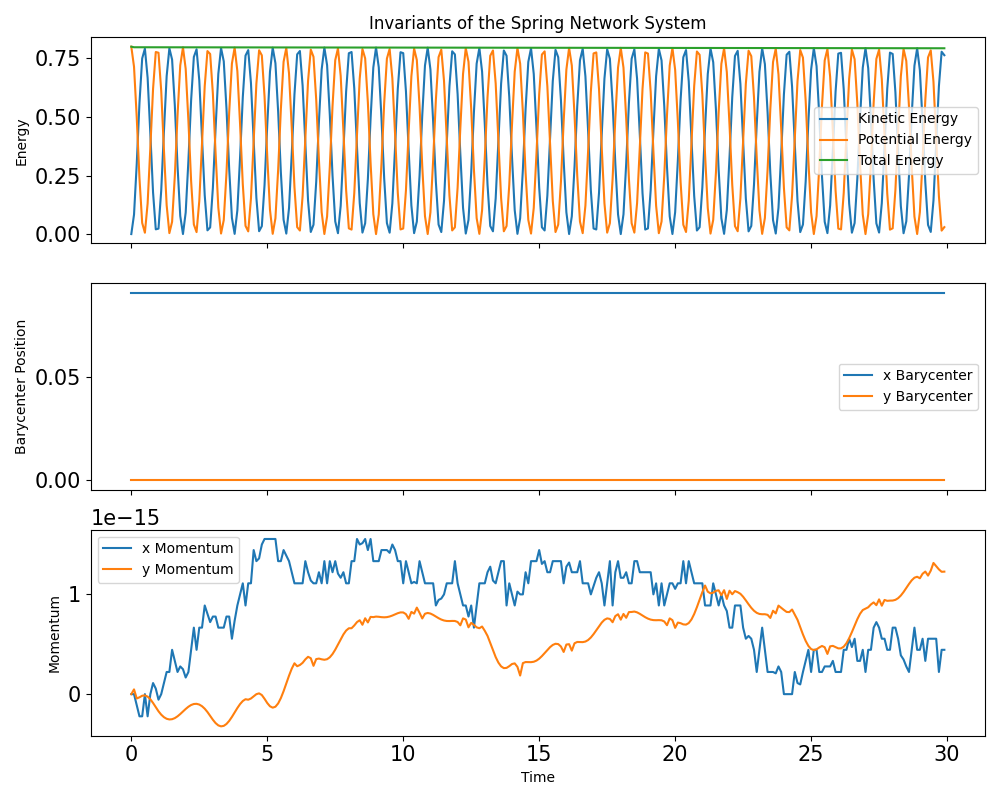

"\nR =hub.get_dfields()\nx = R['x']['value'][:,0,0,:,0]\nm = R['m']['value'][0,0,:,0]\nt = R['time']['value'][:,0,0,0,0]\nKinetic = R['Kinetic']['value'][:,0,0,0,0]\nPotential = R['Potential']['value'][:,0,0,0,0]\n\nplt.close('all')\nplt.figure('trajectory')\nplt.plot(t,x[:,0],label='0')\nplt.plot(t,x[:,1],label='1')\nplt.plot(t,x[:,1]*m[1]+x[:,0]*m[0],label='barycenter')\nplt.legend()\nplt.show()\n\nplt.figure('Energy')\nplt.plot(t,Kinetic,label='kinetic energy')\nplt.plot(t,Potential,label='potential energy')\nplt.plot(t,Kinetic+Potential,label='mechanical energy')\nplt.legend()\nplt.show()\n"

In [38]:
hub=chm.Hub('Spring_Network')

d=dict(
    # Nodes
    Nnodes = 2, 
    x = np.array([0.0, 1.0]), # initial positions
    y = np.array([0.0, 0.0]),
    vx = np.array([0.0, 0.0]), # initial velocities
    vy = np.array([0.0, 0.0]), 
    m = np.array([10.0, 1.0]), # masses

    # Springs
    Nsprings = 1, # number of springs
    Node1 = np.array([0]), # first node index of the spring
    Node2 = np.array([1]), # second node index of the spring
    k = np.array([10.0]), # stiffness
    L0 = np.array([0.6]) # rest length
)

K,L = hub.supplements['Springlist_to_K_L0'](d['Node1'],
                                            d['Node2'],
                                            d['k'],
                                            d['L0'],
                                            d['Nnodes'])

# Integration 
hub.set_fields(Nnodes=d['Nnodes'],
               x=d['x'],
               y=d['y'],
               m=d['m'],
               vx= d['vx'],
               vy= d['vy'],
               damp=0,
               Kmat=K,
               L0Mat=L,
               Tsim=30,
               dt=0.1)
hub.run() 
hub.supplements['plot_spring_network'](hub,sizemass=False)
hub.supplements['plot_invariants'](hub)


Name: Double-spring with one free node


Description: Three nodes in line with two loaded springs, the two external nodes have a very high mass 

In [31]:
hub=chm.Hub('Spring_Network')

d=dict(
    # Nodes
    Nnodes = 3, 
    x = np.array([0, 1,2]), # initial positions
    y = np.array([0, 0,0]),
    vx = np.array([0, 0,0]), # initial velocities
    vy = np.array([0, 0,0]), 
    m = np.array([100000, 1,100000]), # masses

    # Springs
    Nsprings = 2, # number of springs
    Node1 = np.array([0,1]), # first node index of the spring
    Node2 = np.array([1,2]), # second node index of the spring
    k = np.array([10,10]), # stiffness
    L0 = np.array([0.6,1.4]) # rest length
)

K,L = hub.supplements['Springlist_to_K_L0'](d['Node1'],
                                            d['Node2'],
                                            d['k'],
                                            d['L0'],
                                            d['Nnodes'])

# Integration 
hub.set_fields(Nnodes=d['Nnodes'],
               x=d['x'],
               y=d['y'],
               m=d['m'],
               vx= d['vx'],
               vy= d['vy'],
               damp=0,
               Kmat=K,
               L0Mat=L,
               Tsim=300,
               dt=0.05)
hub.run(NtimeOutput=100) 
plot_spring_network(hub,d['Node1'],d['Node2'],d['L0'],sizemass=False)



time step 6000 / 6000


time step 20000 / 20000


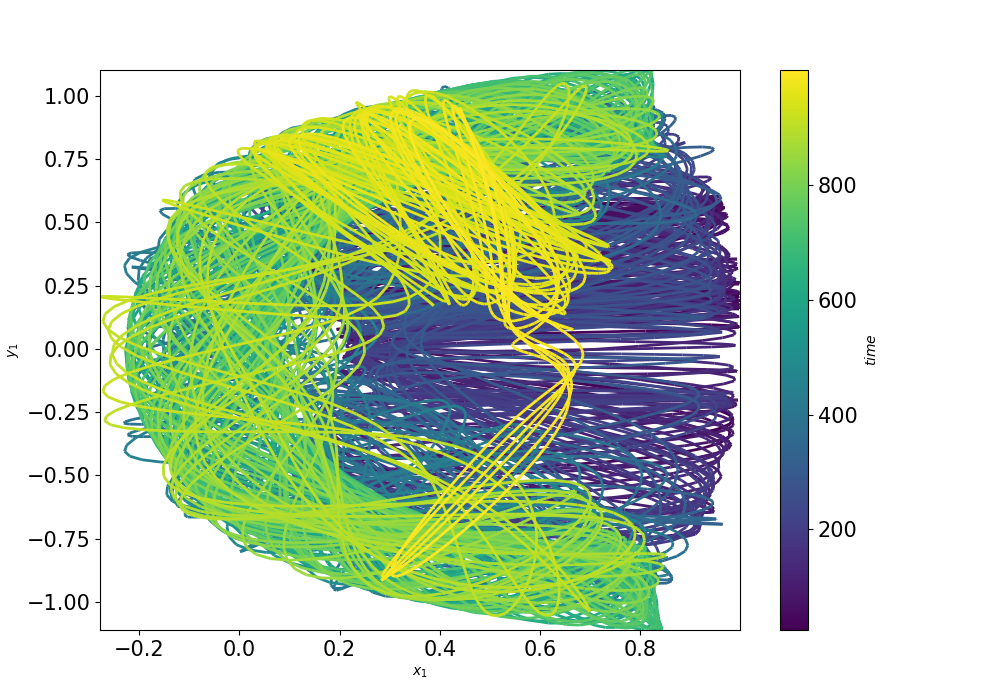

In [5]:
hub=chm.Hub('Spring_Network')

d=dict(
    # Nodes
    Nnodes = 3, 
    x = np.array([0, 1,2]), # initial positions
    y = np.array([0, 0,0]),
    vx = np.array([0, 0,0]), # initial velocities
    vy = np.array([0, 0,0]), 
    m = np.array([100000, 1,100000]), # masses

    # Springs
    Nsprings = 2, # number of springs
    Node1 = np.array([0,1]), # first node index of the spring
    Node2 = np.array([1,2]), # second node index of the spring
    k = np.array([10,10]), # stiffness
    L0 = np.array([0.6,1.4]) # rest length
)

K,L = hub.supplements['Springlist_to_K_L0'](d['Node1'],
                                            d['Node2'],
                                            d['k'],
                                            d['L0'],
                                            d['Nnodes'])

# Integration 
hub.set_fields(Nnodes=d['Nnodes'],
               x=d['x'],
               y=d['y'],
               m=d['m'],
               vx= d['vx'],
               vy= d['vy'],
               damp=0,
               Kmat=K,
               L0Mat=L,
               Tsim=1000,
               dt=0.05)
hub.run()
chm.Plots.XY(hub,['x',1],['y',1],'time',tini=500)


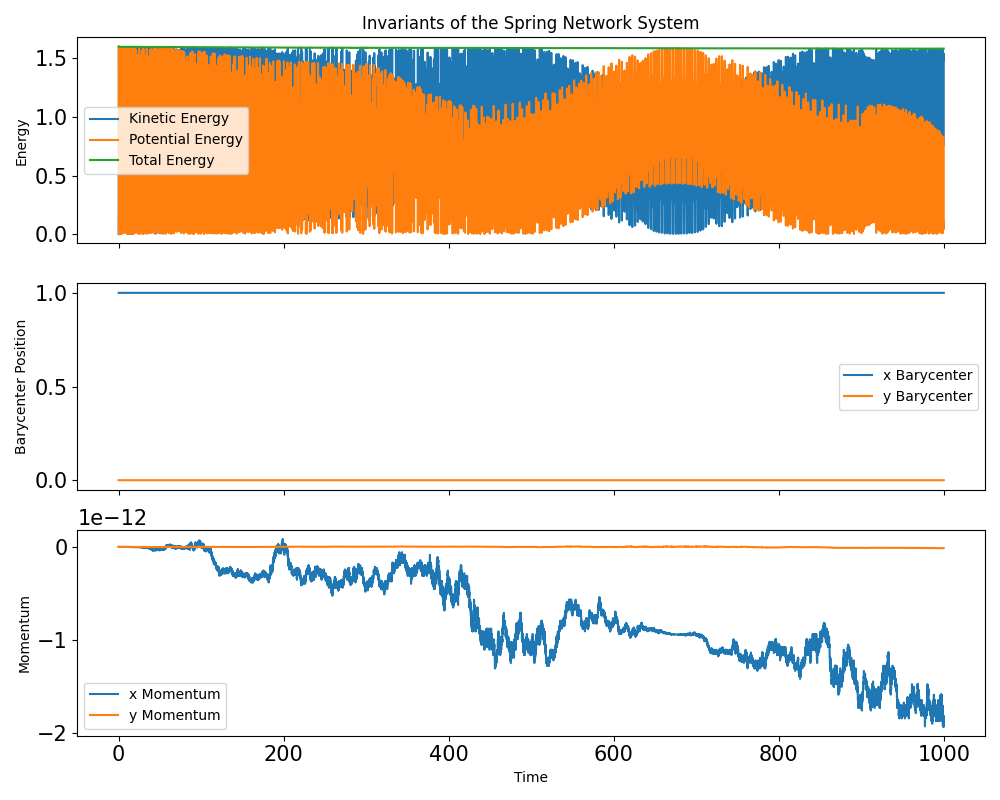

In [7]:
plot_invariants(hub)